In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import csv
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
# Set each environment variable to a notebook variable of the same name
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))


str

str

In [4]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
# Set each environment variable to a notebook variable of the same name
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))


str

str

In [5]:
# Create your Alpaca API REST object by calling Alpaca's tradeapi.REST function
# Set the parameters to your alpaca_api_key, alpaca_secret_key and api_version="v2"
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")


In [6]:
# Format the current date as ISO format
today = pd.Timestamp("2021-09-28", tz="America/New_York").isoformat()

In [7]:
# Set the tickers for the stocks you have chosen
# We are selecting the following 15 (note to group that 14 currently work, but added in VOO)
tickers = ["TSM", "QCOM", "VALE", "AMD", "BHP", "RIO", "FCX", "INTC", "MSFT", "DDD", "NVDA", "TSLA", "AMAT", "F", "VOO"]

In [8]:
# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"

In [9]:
# Get current closing prices for above stocks
df_portfolio = alpaca.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today,
    limit = 500
).df

# Display sample data
# Auto formats in alphabetical order
df_portfolio

AMAT                                         AMD  \
                             open    high       low   close    volume    open   
time                                                                            
2021-09-28 00:00:00-04:00  137.62  139.58  132.5339  132.91  10774137  106.79   

                                                             ...   VALE  \
                             high     low   close    volume  ...   open   
time                                                         ...          
2021-09-28 00:00:00-04:00  107.65  101.42  101.52  71109820  ...  14.35   

                                                            VOO          \
                            high    low close    volume    open    high   
time                                                                      
2021-09-28 00:00:00-04:00  14.41  13.76  13.8  39804576  405.53  405.87   

                                                    
                              low   close   volume  
time                                                
2021-09-28 00:00:00-04:00  399.33  400.09  7903801  

[1 rows x 75 columns]

In [10]:
# The farthest Alpaca will go back is 4 months for one pull
# Format start and end dates as ISO format for one year period
start = pd.Timestamp("2021-05-28", tz="America/New_York").isoformat()
end = pd.Timestamp("2021-09-28", tz="America/New_York").isoformat()

In [11]:
# Get closing prices for chosen stocks from start to end date of choice
df_portfolio_months = alpaca.get_barset(
    tickers,
    timeframe,
    start = start,
    end = end,
    limit = 1000
).df

# Display sample data
df_portfolio_months.head(10)

AMAT                                      AMD  \
                             open    high     low    close   volume   open   
time                                                                         
2021-05-28 00:00:00-04:00  139.10  139.46  137.82  138.130  5352486  78.69   
2021-06-01 00:00:00-04:00  138.98  142.12  137.26  138.200  8172772  81.01   
2021-06-02 00:00:00-04:00  138.10  140.36  136.92  139.010  5701164  81.00   
2021-06-03 00:00:00-04:00  137.13  138.03  135.09  136.380  7450791  81.15   
2021-06-04 00:00:00-04:00  137.80  140.85  137.62  139.860  5760286  80.92   
2021-06-07 00:00:00-04:00  139.22  139.69  138.19  138.970  4654583  81.41   
2021-06-08 00:00:00-04:00  140.34  140.75  135.24  135.849  7075776  81.87   
2021-06-09 00:00:00-04:00  136.85  137.47  134.57  134.680  5859583  81.03   
2021-06-10 00:00:00-04:00  135.89  138.17  135.30  137.170  4925484  80.02   
2021-06-11 00:00:00-04:00  136.82  137.15  135.23  136.810  4774587  81.60   

                                                           ...   VALE  \
                             high    low  close    volume  ...   open   
time                                                       ...          
2021-05-28 00:00:00-04:00  81.090  78.66  80.10  38926159  ...  21.08   
2021-06-01 00:00:00-04:00  82.910  80.66  80.80  41575624  ...  22.69   
2021-06-02 00:00:00-04:00  82.600  80.66  81.99  33784147  ...  22.05   
2021-06-03 00:00:00-04:00  81.890  80.26  80.27  27741701  ...  22.39   
2021-06-04 00:00:00-04:00  82.190  80.81  81.57  24661996  ...  22.68   
2021-06-07 00:00:00-04:00  81.680  80.38  81.33  25756477  ...  22.07   
2021-06-08 00:00:00-04:00  82.645  80.45  80.88  25835849  ...  22.20   
2021-06-09 00:00:00-04:00  81.677  79.80  79.96  26558237  ...  21.97   
2021-06-10 00:00:00-04:00  81.710  79.70  81.55  27148346  ...  22.13   
2021-06-11 00:00:00-04:00  82.330  80.70  81.30  23079467  ...  22.38   

                                                                 VOO  \
                              high     low   close    volume    open   
time                                                                   
2021-05-28 00:00:00-04:00  21.6700  20.950  21.520  37971342  387.03   
2021-06-01 00:00:00-04:00  22.8000  22.060  22.195  39826043  388.50   
2021-06-02 00:00:00-04:00  22.8300  21.975  22.690  42481594  386.43   
2021-06-03 00:00:00-04:00  22.4900  22.010  22.405  25519244  384.17   
2021-06-04 00:00:00-04:00  22.6850  22.255  22.460  18947927  386.81   
2021-06-07 00:00:00-04:00  22.3600  22.070  22.300  23450123  388.52   
2021-06-08 00:00:00-04:00  22.2650  21.790  21.880  25770795  389.00   
2021-06-09 00:00:00-04:00  22.3950  21.851  22.150  30557007  389.08   
2021-06-10 00:00:00-04:00  22.3699  22.000  22.235  33852127  388.86   
2021-06-11 00:00:00-04:00  22.4770  22.140  22.400  22231265  390.00   

                                                              
                               high     low   close   volume  
time                                                          
2021-05-28 00:00:00-04:00  387.2700  385.94  386.14  2989968  
2021-06-01 00:00:00-04:00  388.6200  385.38  385.79  3450288  
2021-06-02 00:00:00-04:00  387.2400  385.47  386.49  3091198  
2021-06-03 00:00:00-04:00  386.1100  382.70  385.09  3161557  
2021-06-04 00:00:00-04:00  388.8000  386.76  388.53  2054784  
2021-06-07 00:00:00-04:00  388.6900  387.25  388.19  2325799  
2021-06-08 00:00:00-04:00  389.0800  386.44  388.22  2240541  
2021-06-09 00:00:00-04:00  389.1300  387.41  387.63  2680519  
2021-06-10 00:00:00-04:00  390.3597  387.58  389.43  2473548  
2021-06-11 00:00:00-04:00  390.2000  388.73  390.09  2090533  

[10 rows x 75 columns]

In [12]:
# Clean the data and drop all columns except for closing
df_portfolio_months_clean = df_portfolio_months.drop(['open', 'low', 'high'], axis=1, level=1)

# Display sample data
df_portfolio_months_clean.head(10)

AMAT             AMD               BHP           \
                             close   volume  close    volume   close   volume   
time                                                                            
2021-05-28 00:00:00-04:00  138.130  5352486  80.10  38926159  74.110   987471   
2021-06-01 00:00:00-04:00  138.200  8172772  80.80  41575624  76.300  1820431   
2021-06-02 00:00:00-04:00  139.010  5701164  81.99  33784147  76.255  1262039   
2021-06-03 00:00:00-04:00  136.380  7450791  80.27  27741701  74.960  1081251   
2021-06-04 00:00:00-04:00  139.860  5760286  81.57  24661996  76.110   934508   
2021-06-07 00:00:00-04:00  138.970  4654583  81.33  25756477  74.830   996814   
2021-06-08 00:00:00-04:00  135.849  7075776  80.88  25835849  76.010  1597693   
2021-06-09 00:00:00-04:00  134.680  5859583  79.96  26558237  74.420  1706570   
2021-06-10 00:00:00-04:00  137.170  4925484  81.55  27148346  75.250  1442458   
2021-06-11 00:00:00-04:00  136.810  4774587  81.30  23079467  75.880   941751   

                               DDD                 F             ...    RIO  \
                             close   volume    close     volume  ...  close   
time                                                             ...          
2021-05-28 00:00:00-04:00  29.4400  6490662  14.5300  141622031  ...  87.43   
2021-06-01 00:00:00-04:00  28.9900  3609828  14.8100   83200280  ...  90.77   
2021-06-02 00:00:00-04:00  32.3300  6547593  14.9000   72766581  ...  90.24   
2021-06-03 00:00:00-04:00  30.2000  4739859  16.0001  168681043  ...  88.49   
2021-06-04 00:00:00-04:00  30.0000  3231828  15.9601  140827381  ...  89.76   
2021-06-07 00:00:00-04:00  31.3900  2921420  15.8750   84837018  ...  88.12   
2021-06-08 00:00:00-04:00  31.1400  3257368  15.6300   88567669  ...  88.61   
2021-06-09 00:00:00-04:00  29.8400  3077182  15.4850   55904052  ...  86.87   
2021-06-10 00:00:00-04:00  29.3000  2414062  15.1200   71476290  ...  86.86   
2021-06-11 00:00:00-04:00  29.8476  2288172  15.2800   45014834  ...  87.48   

                                        TSLA                TSM           \
                            volume     close    volume    close   volume   
time                                                                       
2021-05-28 00:00:00-04:00  1652945  625.7100  21525163  117.360  4767144   
2021-06-01 00:00:00-04:00  3921661  624.0300  17155669  118.510  6880051   
2021-06-02 00:00:00-04:00  2278392  605.0001  22315710  118.930  4634811   
2021-06-03 00:00:00-04:00  2524998  572.8250  28308048  116.826  4321505   
2021-06-04 00:00:00-04:00  2344842  599.3500  22616463  119.620  4946838   
2021-06-07 00:00:00-04:00  2203105  605.0000  21385238  118.220  3669343   
2021-06-08 00:00:00-04:00  1485174  603.5000  24177565  115.930  9913024   
2021-06-09 00:00:00-04:00  2160271  598.7800  15868276  117.130  6058129   
2021-06-10 00:00:00-04:00  1952475  610.1200  22869228  118.220  8090927   
2021-06-11 00:00:00-04:00  1451563  609.8900  15191089  118.290  5750712   

                             VALE               VOO           
                            close    volume   close   volume  
time                                                          
2021-05-28 00:00:00-04:00  21.520  37971342  386.14  2989968  
2021-06-01 00:00:00-04:00  22.195  39826043  385.79  3450288  
2021-06-02 00:00:00-04:00  22.690  42481594  386.49  3091198  
2021-06-03 00:00:00-04:00  22.405  25519244  385.09  3161557  
2021-06-04 00:00:00-04:00  22.460  18947927  388.53  2054784  
2021-06-07 00:00:00-04:00  22.300  23450123  388.19  2325799  
2021-06-08 00:00:00-04:00  21.880  25770795  388.22  2240541  
2021-06-09 00:00:00-04:00  22.150  30557007  387.63  2680519  
2021-06-10 00:00:00-04:00  22.235  33852127  389.43  2473548  
2021-06-11 00:00:00-04:00  22.400  22231265  390.09  2090533  

[10 rows x 30 columns]

In [13]:
# The farthest Alpaca will go back is 4 months for one pull, so we repeat process below
# Format start and end dates as ISO format for four month period
# Use the start date above as the end date below
start_2 = pd.Timestamp("2021-01-01", tz="America/New_York").isoformat()
end_2 = pd.Timestamp("2021-05-27", tz="America/New_York").isoformat()

In [14]:
# Get closing prices for chosen stocks from start to end date of choice
df_portfolio_months_2 = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_2,
    end = end_2,
    limit = 1000
).df

# Clean the data and drop all columns except for closing
df_portfolio_months_2_clean = df_portfolio_months_2.drop(['open', 'low', 'high'], axis=1, level=1)

# Display sample data
df_portfolio_months_2_clean.head(10)

AMAT                AMD              BHP  \
                            close    volume    close    volume  close   
time                                                                    
2021-01-04 00:00:00-05:00   86.87   6569399  92.3000  50507796  67.34   
2021-01-05 00:00:00-05:00   89.61   5917088  92.7700  32831671  69.50   
2021-01-06 00:00:00-05:00   90.83   8178419  90.3200  49271453  71.71   
2021-01-07 00:00:00-05:00   94.57   7545334  95.1000  40915929  73.18   
2021-01-08 00:00:00-05:00   95.57   7955703  94.5800  38955375  73.45   
2021-01-11 00:00:00-05:00   97.97   6548707  97.2500  47034398  71.27   
2021-01-12 00:00:00-05:00  100.01   6204285  95.3500  65474748  71.95   
2021-01-13 00:00:00-05:00   98.04   4433132  91.7600  57503643  71.07   
2021-01-14 00:00:00-05:00  105.81  10548388  90.7900  51843612  73.88   
2021-01-15 00:00:00-05:00  103.15   7243103  88.1502  47390574  70.61   

                                        DDD                   F             \
                            volume    close     volume    close     volume   
time                                                                         
2021-01-04 00:00:00-05:00  2548575  10.4700    2172873   8.5200   80476198   
2021-01-05 00:00:00-05:00  3115275  10.8800    1973790   8.6450   67535397   
2021-01-06 00:00:00-05:00  4438674  11.2400    2736705   8.8422   68520361   
2021-01-07 00:00:00-05:00  2122419  22.9600  191024411   9.0500   70837077   
2021-01-08 00:00:00-05:00  2360227  23.5200  132865958   9.0000   57267427   
2021-01-11 00:00:00-05:00  2078863  27.6400   59262138   9.3000   91818823   
2021-01-12 00:00:00-05:00  2420193  24.2400   41817668   9.7750  238887777   
2021-01-13 00:00:00-05:00  2658966  23.4900   20505749   9.7800  170006163   
2021-01-14 00:00:00-05:00  2052843  32.0000   35360507  10.1700  109783187   
2021-01-15 00:00:00-05:00  1716936  28.2518   20073767   9.8300   97933642   

                           ...    RIO              TSLA               TSM  \
                           ...  close   volume    close    volume   close   
time                       ...                                              
2021-01-04 00:00:00-05:00  ...  77.42  2421955  729.750  45293360  111.71   
2021-01-05 00:00:00-05:00  ...  79.26  2207083  735.055  28402584  112.74   
2021-01-06 00:00:00-05:00  ...  82.82  2628211  756.460  41989335  115.60   
2021-01-07 00:00:00-05:00  ...  85.98  2821171  816.240  48080256  121.43   
2021-01-08 00:00:00-05:00  ...  86.68  2325546  880.030  71814487  118.64   
2021-01-11 00:00:00-05:00  ...  83.79  2990361  811.180  55755718  122.55   
2021-01-12 00:00:00-05:00  ...  84.02  3299591  849.220  43550554  122.96   
2021-01-13 00:00:00-05:00  ...  81.76  3947822  854.420  31050197  119.27   
2021-01-14 00:00:00-05:00  ...  84.84  1563476  844.210  29982086  126.29   
2021-01-15 00:00:00-05:00  ...  80.47  1909227  826.160  36516827  125.24   

                                       VALE               VOO           
                             volume   close    volume   close   volume  
time                                                                    
2021-01-04 00:00:00-05:00   9813019  17.400  43157459  339.03  5014185  
2021-01-05 00:00:00-05:00  10259226  17.695  37353783  341.28  3144296  
2021-01-06 00:00:00-05:00  10237526  18.150  37410433  343.43  4701118  
2021-01-07 00:00:00-05:00  12843142  18.930  70417214  348.44  3501103  
2021-01-08 00:00:00-05:00  18508139  18.920  41204672  350.42  3705025  
2021-01-11 00:00:00-05:00  11446712  18.610  34821569  348.22  2946639  
2021-01-12 00:00:00-05:00  26061376  18.700  47528155  348.20  2235336  
2021-01-13 00:00:00-05:00  39810864  18.150  41313192  349.04  3009076  
2021-01-14 00:00:00-05:00  34992522  18.935  24812759  347.88  3438115  
2021-01-15 00:00:00-05:00  16395447  17.640  33115891  345.34  3551537  

[10 rows x 30 columns]

In [15]:
# The farthest Alpaca will go back is 4 months for one pull, so we repeat process below
# Format start and end dates as ISO format for four month period
# Use the start date above as the end date below

start_3 = pd.Timestamp("2020-09-28", tz="America/New_York").isoformat()
end_3 = pd.Timestamp("2021-01-01", tz="America/New_York").isoformat()

df_portfolio_months_3 = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_3,
    end = end_3,
    limit = 1000
).df

# Clean the data and drop all columns except for closing
df_portfolio_months_3_clean = df_portfolio_months_3.drop(['open', 'low', 'high'], axis=1, level=1)

# Display sample data
df_portfolio_months_3_clean.head(10)

AMAT               AMD              BHP           \
                           close   volume    close    volume  close   volume   
time                                                                           
2020-09-28 00:00:00-04:00  59.31  6260486  79.5200  43111531  52.74  1874323   
2020-09-29 00:00:00-04:00  59.67  4501381  81.7500  59458078  51.60  4594819   
2020-09-30 00:00:00-04:00  59.44  5961801  81.9301  46458134  51.70  3566851   
2020-10-01 00:00:00-04:00  60.64  6330692  84.8900  49642884  51.33  3357198   
2020-10-02 00:00:00-04:00  58.21  5672323  81.8400  48631616  51.44  3793716   
2020-10-05 00:00:00-04:00  60.61  4792765  86.1400  45148897  52.18  2730693   
2020-10-06 00:00:00-04:00  60.37  5480957  84.4890  48489425  50.49  8792307   
2020-10-07 00:00:00-04:00  61.12  4244719  86.6900  41338926  51.93  4477103   
2020-10-08 00:00:00-04:00  62.59  4463596  86.4900  52691394  52.53  4279595   
2020-10-09 00:00:00-04:00  63.29  5239514  83.1300  73391903  52.87  2980887   

                            DDD                F             ...     RIO  \
                          close    volume  close     volume  ...   close   
time                                                         ...           
2020-09-28 00:00:00-04:00  4.79   1710523  6.695   43985784  ...  60.500   
2020-09-29 00:00:00-04:00  4.92   4524660  6.590   72171314  ...  60.215   
2020-09-30 00:00:00-04:00  4.90   3508832  6.650   92055328  ...  60.410   
2020-10-01 00:00:00-04:00  4.87   2757108  6.745   98263431  ...  59.840   
2020-10-02 00:00:00-04:00  4.87   3008264  6.890  101610232  ...  60.490   
2020-10-05 00:00:00-04:00  4.98   2210936  7.020   76437587  ...  61.210   
2020-10-06 00:00:00-04:00  5.36  10100940  6.980  136568021  ...  59.610   
2020-10-07 00:00:00-04:00  6.35  47238769  7.240   91439527  ...  61.210   
2020-10-08 00:00:00-04:00  6.39  16155566  7.350   98377056  ...  61.520   
2020-10-09 00:00:00-04:00  6.68  12029963  7.245   92953786  ...  62.090   

                                        TSLA              TSM            \
                            volume     close    volume  close    volume   
time                                                                      
2020-09-28 00:00:00-04:00  3067588  421.0602  46468845  79.77   5615288   
2020-09-29 00:00:00-04:00  4924997  418.9900  47939292  80.52  11476689   
2020-09-30 00:00:00-04:00  3850541  428.9700  45355318  81.07  11016860   
2020-10-01 00:00:00-04:00  3094476  447.8100  46917693  82.62  11386804   
2020-10-02 00:00:00-04:00  4739088  415.2699  64001779  80.81  10972596   
2020-10-05 00:00:00-04:00  2490418  425.5000  42071439  84.54  19355676   
2020-10-06 00:00:00-04:00  5252880  413.7001  46076914  83.11  14815509   
2020-10-07 00:00:00-04:00  3758027  425.1900  40832057  86.92  20963801   
2020-10-08 00:00:00-04:00  2653720  425.9200  38297823  87.80  21227801   
2020-10-09 00:00:00-04:00  7039339  433.9600  27687361  88.80  14203507   

                             VALE                 VOO           
                            close    volume     close   volume  
time                                                            
2020-09-28 00:00:00-04:00  10.480  37147138  308.3200  2376657  
2020-09-29 00:00:00-04:00  10.410  53507461  305.3100  2197225  
2020-09-30 00:00:00-04:00  10.580  51168819  307.6100  4091286  
2020-10-01 00:00:00-04:00  10.415  41588198  309.5800  2823625  
2020-10-02 00:00:00-04:00  10.390  46358919  306.6900  3051150  
2020-10-05 00:00:00-04:00  10.760  43451278  312.0502  2271456  
2020-10-06 00:00:00-04:00  10.490  45778814  307.6400  3196192  
2020-10-07 00:00:00-04:00  10.750  58942955  312.9900  1641170  
2020-10-08 00:00:00-04:00  11.055  55817062  315.7500  1651404  
2020-10-09 00:00:00-04:00  11.195  50762476  318.6200  2706724  

[10 rows x 30 columns]

In [16]:
#Combine all the cleaned data into one table by using concat
merged_portfolio = pd.concat([df_portfolio_months_3_clean, df_portfolio_months_2_clean, df_portfolio_months_clean])

# Display the head and tail of the newly merged portfolio
display(merged_portfolio.head())
display(merged_portfolio.tail())

AMAT               AMD              BHP           \
                           close   volume    close    volume  close   volume   
time                                                                           
2020-09-28 00:00:00-04:00  59.31  6260486  79.5200  43111531  52.74  1874323   
2020-09-29 00:00:00-04:00  59.67  4501381  81.7500  59458078  51.60  4594819   
2020-09-30 00:00:00-04:00  59.44  5961801  81.9301  46458134  51.70  3566851   
2020-10-01 00:00:00-04:00  60.64  6330692  84.8900  49642884  51.33  3357198   
2020-10-02 00:00:00-04:00  58.21  5672323  81.8400  48631616  51.44  3793716   

                            DDD               F             ...     RIO  \
                          close   volume  close     volume  ...   close   
time                                                        ...           
2020-09-28 00:00:00-04:00  4.79  1710523  6.695   43985784  ...  60.500   
2020-09-29 00:00:00-04:00  4.92  4524660  6.590   72171314  ...  60.215   
2020-09-30 00:00:00-04:00  4.90  3508832  6.650   92055328  ...  60.410   
2020-10-01 00:00:00-04:00  4.87  2757108  6.745   98263431  ...  59.840   
2020-10-02 00:00:00-04:00  4.87  3008264  6.890  101610232  ...  60.490   

                                        TSLA              TSM            \
                            volume     close    volume  close    volume   
time                                                                      
2020-09-28 00:00:00-04:00  3067588  421.0602  46468845  79.77   5615288   
2020-09-29 00:00:00-04:00  4924997  418.9900  47939292  80.52  11476689   
2020-09-30 00:00:00-04:00  3850541  428.9700  45355318  81.07  11016860   
2020-10-01 00:00:00-04:00  3094476  447.8100  46917693  82.62  11386804   
2020-10-02 00:00:00-04:00  4739088  415.2699  64001779  80.81  10972596   

                             VALE               VOO           
                            close    volume   close   volume  
time                                                          
2020-09-28 00:00:00-04:00  10.480  37147138  308.32  2376657  
2020-09-29 00:00:00-04:00  10.410  53507461  305.31  2197225  
2020-09-30 00:00:00-04:00  10.580  51168819  307.61  4091286  
2020-10-01 00:00:00-04:00  10.415  41588198  309.58  2823625  
2020-10-02 00:00:00-04:00  10.390  46358919  306.69  3051150  

[5 rows x 30 columns]

AMAT                 AMD              BHP  \
                            close    volume     close    volume  close   
time                                                                     
2021-09-22 00:00:00-04:00  138.10   5499382  104.3874  32420839  55.01   
2021-09-23 00:00:00-04:00  141.11   5022612  106.1500  31320213  55.06   
2021-09-24 00:00:00-04:00  141.94   3235463  105.8000  25412547  54.53   
2021-09-27 00:00:00-04:00  142.74   4500169  108.1400  50368251  55.07   
2021-09-28 00:00:00-04:00  132.91  10774137  101.5200  71109820  52.55   

                                      DDD                F            ...  \
                            volume  close   volume   close    volume  ...   
time                                                                  ...   
2021-09-22 00:00:00-04:00  5170304  29.00  1343670  13.240  68361903  ...   
2021-09-23 00:00:00-04:00  8138224  29.49  1307111  13.700  65450567  ...   
2021-09-24 00:00:00-04:00  3004601  29.15  1488537  13.780  52066001  ...   
2021-09-27 00:00:00-04:00  3129419  29.80  1323481  14.169  63099249  ...   
2021-09-28 00:00:00-04:00  6039317  28.55  1220898  14.315  96226953  ...   

                               RIO             TSLA               TSM  \
                             close   volume   close    volume   close   
time                                                                    
2021-09-22 00:00:00-04:00  66.6100  5814441  751.75  13586028  115.93   
2021-09-23 00:00:00-04:00  67.0500  3561548  753.68  11244060  116.18   
2021-09-24 00:00:00-04:00  66.7695  3280825  774.54  20458573  115.62   
2021-09-27 00:00:00-04:00  67.5400  3328176  791.40  26193857  116.16   
2021-09-28 00:00:00-04:00  65.8500  4954738  777.56  23562104  111.86   

                                     VALE               VOO           
                            volume  close    volume   close   volume  
time                                                                  
2021-09-22 00:00:00-04:00  4865158  16.42  50059762  403.86  5462282  
2021-09-23 00:00:00-04:00  4942588  14.82  48252357  408.73  3747855  
2021-09-24 00:00:00-04:00  4194719  14.49  33550901  409.46  3204191  
2021-09-27 00:00:00-04:00  4333765  14.55  44261902  408.31  3370305  
2021-09-28 00:00:00-04:00  9085028  13.80  39804576  400.09  7903801  

[5 rows x 30 columns]

In [17]:
# Send to CSV file

merged_portfolio.to_csv('cleaned_stock_data.csv')

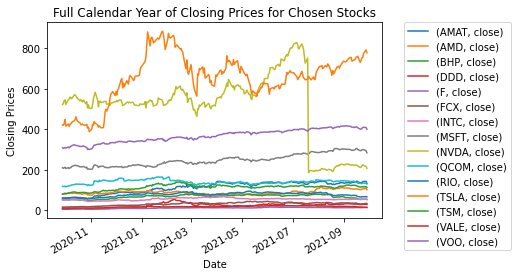

In [18]:
# Graph your stocks closing prices over the course of the last year by using the data you just merged into one portfolio
# We are graphing the data to get a visualization over the stock closing price performance over the last year

# First remove the volume column from the portfolio to just plot the closing prices
merged_portfolio_close_dates = merged_portfolio.drop(['volume'], axis=1, level=1)

merged_portfolio_close_dates.plot()
plt.title('Full Calendar Year of Closing Prices for Chosen Stocks')
plt.ylabel('Closing Prices')
plt.xlabel('Date')
plt.legend(loc="lower right", bbox_to_anchor=(1.4, -0.19), ncol=1)

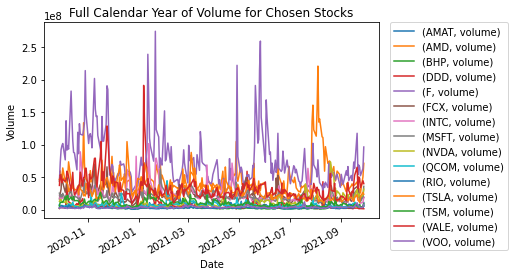

In [19]:
# Graph your stocks daily volume over the course of the last year by using the data you just merged into one portfolio
# We are graphing the data to get a visualization over the changes in volume over the last year

# First remove the close column from the portfolio to just plot the volume
merged_portfolio_volumes = merged_portfolio.drop(['close'], axis=1, level=1)

merged_portfolio_volumes.plot()
plt.title('Full Calendar Year of Volume for Chosen Stocks')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.legend(loc="lower right", bbox_to_anchor=(1.4, -0.19), ncol=1)

In [20]:
# Create a Lagged Volume column that shifts the volume of each stock back by one day

# Since there are multiple columns with the name volume, we must create a loop 
for widget in merged_portfolio.columns.levels[0]:
    merged_portfolio.loc[:,(widget, 'lagged volume')] = merged_portfolio[(widget, 'volume')].shift(1)

# Then we sort the columns to show within each stock
merged_portfolio = merged_portfolio.sort_index(axis=1, level=0)

#Drop NA values
merged_portfolio.dropna(inplace=True)

#Display portfolio 
merged_portfolio.head(10)

AMAT                             AMD  \
                           close lagged volume   volume    close   
time                                                               
2020-09-29 00:00:00-04:00  59.67     6260486.0  4501381  81.7500   
2020-09-30 00:00:00-04:00  59.44     4501381.0  5961801  81.9301   
2020-10-01 00:00:00-04:00  60.64     5961801.0  6330692  84.8900   
2020-10-02 00:00:00-04:00  58.21     6330692.0  5672323  81.8400   
2020-10-05 00:00:00-04:00  60.61     5672323.0  4792765  86.1400   
2020-10-06 00:00:00-04:00  60.37     4792765.0  5480957  84.4890   
2020-10-07 00:00:00-04:00  61.12     5480957.0  4244719  86.6900   
2020-10-08 00:00:00-04:00  62.59     4244719.0  4463596  86.4900   
2020-10-09 00:00:00-04:00  63.29     4463596.0  5239514  83.1300   
2020-10-12 00:00:00-04:00  64.68     5239514.0  5853751  84.2900   

                                                     BHP                \
                          lagged volume    volume  close lagged volume   
time                                                                     
2020-09-29 00:00:00-04:00    43111531.0  59458078  51.60     1874323.0   
2020-09-30 00:00:00-04:00    59458078.0  46458134  51.70     4594819.0   
2020-10-01 00:00:00-04:00    46458134.0  49642884  51.33     3566851.0   
2020-10-02 00:00:00-04:00    49642884.0  48631616  51.44     3357198.0   
2020-10-05 00:00:00-04:00    48631616.0  45148897  52.18     3793716.0   
2020-10-06 00:00:00-04:00    45148897.0  48489425  50.49     2730693.0   
2020-10-07 00:00:00-04:00    48489425.0  41338926  51.93     8792307.0   
2020-10-08 00:00:00-04:00    41338926.0  52691394  52.53     4477103.0   
2020-10-09 00:00:00-04:00    52691394.0  73391903  52.87     4279595.0   
2020-10-12 00:00:00-04:00    73391903.0  44277174  52.49     2980887.0   

                                     DDD  ...      TSLA    TSM                \
                            volume close  ...    volume  close lagged volume   
time                                      ...                                  
2020-09-29 00:00:00-04:00  4594819  4.92  ...  47939292  80.52     5615288.0   
2020-09-30 00:00:00-04:00  3566851  4.90  ...  45355318  81.07    11476689.0   
2020-10-01 00:00:00-04:00  3357198  4.87  ...  46917693  82.62    11016860.0   
2020-10-02 00:00:00-04:00  3793716  4.87  ...  64001779  80.81    11386804.0   
2020-10-05 00:00:00-04:00  2730693  4.98  ...  42071439  84.54    10972596.0   
2020-10-06 00:00:00-04:00  8792307  5.36  ...  46076914  83.11    19355676.0   
2020-10-07 00:00:00-04:00  4477103  6.35  ...  40832057  86.92    14815509.0   
2020-10-08 00:00:00-04:00  4279595  6.39  ...  38297823  87.80    20963801.0   
2020-10-09 00:00:00-04:00  2980887  6.68  ...  27687361  88.80    21227801.0   
2020-10-12 00:00:00-04:00  2255621  6.75  ...  36564876  90.92    14203507.0   

                                       VALE                               VOO  \
                             volume   close lagged volume    volume     close   
time                                                                            
2020-09-29 00:00:00-04:00  11476689  10.410    37147138.0  53507461  305.3100   
2020-09-30 00:00:00-04:00  11016860  10.580    53507461.0  51168819  307.6100   
2020-10-01 00:00:00-04:00  11386804  10.415    51168819.0  41588198  309.5800   
2020-10-02 00:00:00-04:00  10972596  10.390    41588198.0  46358919  306.6900   
2020-10-05 00:00:00-04:00  19355676  10.760    46358919.0  43451278  312.0502   
2020-10-06 00:00:00-04:00  14815509  10.490    43451278.0  45778814  307.6400   
2020-10-07 00:00:00-04:00  20963801  10.750    45778814.0  58942955  312.9900   
2020-10-08 00:00:00-04:00  21227801  11.055    58942955.0  55817062  315.7500   
2020-10-09 00:00:00-04:00  14203507  11.195    55817062.0  50762476  318.6200   
2020-10-12 00:00:00-04:00  19502536  11.220    50762476.0  28695057  323.7700   

                                                  
                          lagged v

In [21]:
# Create a Daily Stock Return column that will calculate the daily percent change of the closing stock prices

# Since there are multiple columns with the name close, we must create a loop 

for stock in merged_portfolio.columns.levels[0]:
    merged_portfolio.loc[:,(stock, 'daily return')] = merged_portfolio[(stock, 'close')].pct_change()

# Then we sort the columns to show within each stock
merged_portfolio = merged_portfolio.sort_index(axis=1, level=0)

#Display first and last five rows of the portfolio 
display(merged_portfolio.head())
display(merged_portfolio.tail())

AMAT                                          AMD  \
                           close daily return lagged volume   volume    close   
time                                                                            
2020-09-29 00:00:00-04:00  59.67          NaN     6260486.0  4501381  81.7500   
2020-09-30 00:00:00-04:00  59.44    -0.003855     4501381.0  5961801  81.9301   
2020-10-01 00:00:00-04:00  60.64     0.020188     5961801.0  6330692  84.8900   
2020-10-02 00:00:00-04:00  58.21    -0.040073     6330692.0  5672323  81.8400   
2020-10-05 00:00:00-04:00  60.61     0.041230     5672323.0  4792765  86.1400   

                                                                  BHP  \
                          daily return lagged volume    volume  close   
time                                                                    
2020-09-29 00:00:00-04:00          NaN    43111531.0  59458078  51.60   
2020-09-30 00:00:00-04:00     0.002203    59458078.0  46458134  51.70   
2020-10-01 00:00:00-04:00     0.036127    46458134.0  49642884  51.33   
2020-10-02 00:00:00-04:00    -0.035929    49642884.0  48631616  51.44   
2020-10-05 00:00:00-04:00     0.052542    48631616.0  45148897  52.18   

                                        ...           TSM              VALE  \
                          daily return  ... lagged volume    volume   close   
time                                    ...                                   
2020-09-29 00:00:00-04:00          NaN  ...     5615288.0  11476689  10.410   
2020-09-30 00:00:00-04:00     0.001938  ...    11476689.0  11016860  10.580   
2020-10-01 00:00:00-04:00    -0.007157  ...    11016860.0  11386804  10.415   
2020-10-02 00:00:00-04:00     0.002143  ...    11386804.0  10972596  10.390   
2020-10-05 00:00:00-04:00     0.014386  ...    10972596.0  19355676  10.760   

                                                                     VOO  \
                          daily return lagged volume    volume     close   
time                                                                       
2020-09-29 00:00:00-04:00          NaN    37147138.0  53507461  305.3100   
2020-09-30 00:00:00-04:00     0.016330    53507461.0  51168819  307.6100   
2020-10-01 00:00:00-04:00    -0.015595    51168819.0  41588198  309.5800   
2020-10-02 00:00:00-04:00    -0.002400    41588198.0  46358919  306.6900   
2020-10-05 00:00:00-04:00     0.035611    46358919.0  43451278  312.0502   

                                                               
                          daily return lagged volume   volume  
time                                                           
2020-09-29 00:00:00-04:00          NaN     2376657.0  2197225  
2020-09-30 00:00:00-04:00     0.007533     2197225.0  4091286  
2020-10-01 00:00:00-04:00     0.006404     4091286.0  2823625  
2020-10-02 00:00:00-04:00    -0.009335     2823625.0  3051150  
2020-10-05 00:00:00-04:00     0.017478     3051150.0  2271456  

[5 rows x 60 columns]

AMAT                                       \
                            close daily return lagged volume    volume   
time                                                                     
2021-09-22 00:00:00-04:00  138.10     0.021601     5196327.0   5499382   
2021-09-23 00:00:00-04:00  141.11     0.021796     5499382.0   5022612   
2021-09-24 00:00:00-04:00  141.94     0.005882     5022612.0   3235463   
2021-09-27 00:00:00-04:00  142.74     0.005636     3235463.0   4500169   
2021-09-28 00:00:00-04:00  132.91    -0.068866     4500169.0  10774137   

                                AMD                                       \
                              close daily return lagged volume    volume   
time                                                                       
2021-09-22 00:00:00-04:00  104.3874     0.015442    33527214.0  32420839   
2021-09-23 00:00:00-04:00  106.1500     0.016885    32420839.0  31320213   
2021-09-24 00:00:00-04:00  105.8000    -0.003297    31320213.0  25412547   
2021-09-27 00:00:00-04:00  108.1400     0.022117    25412547.0  50368251   
2021-09-28 00:00:00-04:00  101.5200    -0.061217    50368251.0  71109820   

                             BHP               ...           TSM           \
                           close daily return  ... lagged volume   volume   
time                                           ...                          
2021-09-22 00:00:00-04:00  55.01     0.008433  ...     7049744.0  4865158   
2021-09-23 00:00:00-04:00  55.06     0.000909  ...     4865158.0  4942588   
2021-09-24 00:00:00-04:00  54.53    -0.009626  ...     4942588.0  4194719   
2021-09-27 00:00:00-04:00  55.07     0.009903  ...     4194719.0  4333765   
2021-09-28 00:00:00-04:00  52.55    -0.045760  ...     4333765.0  9085028   

                            VALE                                          VOO  \
                           close daily return lagged volume    volume   close   
time                                                                            
2021-09-22 00:00:00-04:00  16.42     0.033530    32065880.0  50059762  403.86   
2021-09-23 00:00:00-04:00  14.82    -0.097442    50059762.0  48252357  408.73   
2021-09-24 00:00:00-04:00  14.49    -0.022267    48252357.0  33550901  409.46   
2021-09-27 00:00:00-04:00  14.55     0.004141    33550901.0  44261902  408.31   
2021-09-28 00:00:00-04:00  13.80    -0.051546    44261902.0  39804576  400.09   

                                                               
                          daily return lagged volume   volume  
time                                                           
2021-09-22 00:00:00-04:00     0.009548     6143394.0  5462282  
2021-09-23 00:00:00-04:00     0.012059     5462282.0  3747855  
2021-09-24 00:00:00-04:00     0.001786     3747855.0  3204191  
2021-09-27 00:00:00-04:00    -0.002809     3204191.0  3370305  
2021-09-28 00:00:00-04:00    -0.020132     3370305.0  7903801  

[5 rows x 60 columns]

In [22]:
# Create a Stock Volatility column that will calculate the standard deviation of the closing stock prices

# Since there are multiple columns with the name close, we must create a loop 

for volatility in merged_portfolio.columns.levels[0]:
    merged_portfolio.loc[:,(volatility, 'stock volatility')] = merged_portfolio[(volatility, 'close')].pct_change().rolling(window=200).std()

# Then we sort the columns to show within each stock
merged_portfolio = merged_portfolio.sort_index(axis=1, level=0)

#Display portfolio 
merged_portfolio.tail(10)

AMAT                                              \
                            close daily return lagged volume stock volatility   
time                                                                            
2021-09-15 00:00:00-04:00  141.24     0.007849     7113233.0         0.027436   
2021-09-16 00:00:00-04:00  144.05     0.019895     4920828.0         0.027459   
2021-09-17 00:00:00-04:00  140.80    -0.022562     7534315.0         0.027487   
2021-09-20 00:00:00-04:00  135.56    -0.037216     7013359.0         0.027625   
2021-09-21 00:00:00-04:00  135.18    -0.002803     6870640.0         0.027624   
2021-09-22 00:00:00-04:00  138.10     0.021601     5196327.0         0.027577   
2021-09-23 00:00:00-04:00  141.11     0.021796     5499382.0         0.027610   
2021-09-24 00:00:00-04:00  141.94     0.005882     5022612.0         0.027610   
2021-09-27 00:00:00-04:00  142.74     0.005636     3235463.0         0.027557   
2021-09-28 00:00:00-04:00  132.91    -0.068866     4500169.0         0.028019   

                                          AMD                             \
                             volume     close daily return lagged volume   
time                                                                       
2021-09-15 00:00:00-04:00   4920828  105.6000    -0.001041    39534725.0   
2021-09-16 00:00:00-04:00   7534315  106.2200     0.005871    36609065.0   
2021-09-17 00:00:00-04:00   7013359  103.8700    -0.022124    37106146.0   
2021-09-20 00:00:00-04:00   6870640  101.5600    -0.022239    37730356.0   
2021-09-21 00:00:00-04:00   5196327  102.8000     0.012210    42537201.0   
2021-09-22 00:00:00-04:00   5499382  104.3874     0.015442    33527214.0   
2021-09-23 00:00:00-04:00   5022612  106.1500     0.016885    32420839.0   
2021-09-24 00:00:00-04:00   3235463  105.8000    -0.003297    31320213.0   
2021-09-27 00:00:00-04:00   4500169  108.1400     0.022117    25412547.0   
2021-09-28 00:00:00-04:00  10774137  101.5200    -0.061217    50368251.0   

                                                      ...     VALE  \
                          stock volatility    volume  ...    close   
time                                                  ...            
2021-09-15 00:00:00-04:00         0.024166  36609065  ...  17.6200   
2021-09-16 00:00:00-04:00         0.023767  37106146  ...  16.7100   
2021-09-17 00:00:00-04:00         0.023823  37730356  ...  16.3050   
2021-09-20 00:00:00-04:00         0.023865  42537201  ...  15.6450   
2021-09-21 00:00:00-04:00         0.023851  33527214  ...  15.8873   
2021-09-22 00:00:00-04:00         0.023840  32420839  ...  16.4200   
2021-09-23 00:00:00-04:00         0.023867  31320213  ...  14.8200   
2021-09-24 00:00:00-04:00         0.023850  25412547  ...  14.4900   
2021-09-27 00:00:00-04:00         0.023774  50368251  ...  14.5500   
2021-09-28 00:00:00-04:00         0.024141  71109820  ...  13.8000   

                                                                       \
                          daily return lagged volume stock volatility   
time                                                                    
2021-09-15 00:00:00-04:00    -0.011778    28083079.0         0.023745   
2021-09-16 00:00:00-04:00    -0.051646    26112870.0         0.024023   
2021-09-17 00:00:00-04:00    -0.024237    40480376.0         0.023535   
2021-09-20 00:00:00-04:00    -0.040478    52554569.0         0.023672   
2021-09-21 00:00:00-04:00     0.015487    64986425.0         0.023696   
2021-09-22 00:00:00-04:00     0.033530    32065880.0         0.023582   
2021-09-23 00:00:00-04:00    -0.097442    50059762.0         0.024555   
2021-09-24 00:00:00-04:00    -0.022267    48252357.0         0.024601   
2021-09-27 00:00:00-04:00     0.004141    33550901.0         0.024601   
2021-09-28 00:00:00-04:00    -0.051546    44261902.0         0.024543   

                                          VOO                             \
                             volume     close dai

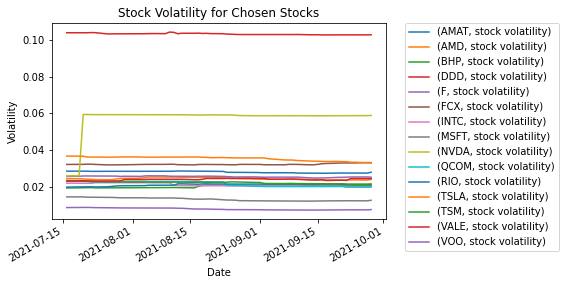

In [23]:
# Graph your stock volatility over the course of the last year by using the data you calculated above
# We are graphing the data to get a visualization over the stock volatility over the last year

# First remove the close, volume, lagged volume, and daily return columns from the portfolio to just plot the volume

merged_portfolio_stock_volatility = merged_portfolio.drop(['close', 'volume', 'lagged volume', 'daily return'], axis=1, level=1)

merged_portfolio_stock_volatility.plot()
plt.title('Stock Volatility for Chosen Stocks')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.legend(loc="lower right", bbox_to_anchor=(1.53, -0.19), ncol=1)

In [24]:
# Creating a correlation table of the daily stock return, lagged volume, and stock volatility

merged_portfolio_corr = merged_portfolio.drop(['close', 'volume'], axis=1, level=1)

merged_portfolio_corr.corr()

AMAT                                 \
                      daily return lagged volume stock volatility   
AMAT daily return         1.000000      0.084675        -0.094382   
     lagged volume        0.084675      1.000000         0.134955   
     stock volatility    -0.094382      0.134955         1.000000   
AMD  daily return         0.577018      0.043326         0.176506   
     lagged volume       -0.032369     -0.086034         0.493536   
     stock volatility    -0.115647      0.185137         0.688358   
BHP  daily return         0.383559      0.031763         0.041689   
     lagged volume        0.087132      0.021731        -0.294959   
     stock volatility     0.026279      0.043424        -0.788874   
DDD  daily return         0.280572     -0.015536         0.032250   
     lagged volume        0.028785      0.062713         0.248687   
     stock volatility    -0.059703      0.114461         0.865946   
F    daily return         0.219394      0.093943        -0.213704   
     lagged volume        0.066880      0.001250        -0.162600   
     stock volatility     0.010921     -0.062621         0.914894   
FCX  daily return         0.382571      0.000964         0.004646   
     lagged volume        0.071363      0.178161        -0.113800   
     stock volatility    -0.182302     -0.136101        -0.453976   
INTC daily return         0.557247      0.057374        -0.111934   
     lagged volume        0.075822      0.083566         0.207962   
     stock volatility     0.062416     -0.215632         0.702051   
MSFT daily return         0.519889      0.126887         0.206747   
     lagged volume        0.078861      0.246368         0.046401   
     stock volatility    -0.042059     -0.000101         0.904280   
NVDA daily return         0.228299      0.031551        -0.113045   
     lagged volume        0.023003     -0.012235         0.053110   
     stock volatility     0.169865     -0.045298        -0.172902   
QCOM daily return         0.638263      0.058807         0.185679   
     lagged volume        0.035803      0.256465         0.057316   
     stock volatility    -0.015375      0.143512         0.965808   
RIO  daily return         0.395471      0.014143        -0.048826   
     lagged volume        0.085645      0.078181        -0.313115   
     stock volatility    -0.069237      0.195115        -0.557630   
TSLA daily return         0.444210     -0.019936        -0.048718   
     lagged volume        0.085886      0.105267         0.162599   
     stock volatility     0.059993      0.068356         0.857360   
TSM  daily return         0.743893      0.023126        -0.033791   
     lagged volume        0.117466      0.204688         0.078765   
     stock volatility     0.046591      0.084352         0.853685   
VALE daily return         0.313643     -0.004393         0.074862   
     lagged volume        0.085238     -0.005503        -0.340694   
     stock volatility    -0.006335     -0.019072        -0.259182   
VOO  daily return         0.645630      0.134363         0.121258   
     lagged volume        0.141213      0.350822        -0.163740   
     stock volatility    -0.022088     -0.049153         0.875743   

                               AMD                                 \
                      daily return lagged volume stock volatility   
AMAT daily return         0.577018     -0.032369        -0.115647   
     lagged volume        0.043326     -0.086034         0.185137   
     stock volatility     0.176506      0.493536         0.688358   
AMD  daily return         1.000000     -0.018761        -0.058628   
     lagged volume       -0.018761      1.000000         0.707880   
     stock volatility    -0.058628      0.707880         1.000000   
BHP  daily return         0.207551     -0.107597        -0.098751   
     lagged volume       -0.027374      0.040446        -0.124186   
     stock volatility    -0.250665     -0.470110        -0.371674   
DDD  daily return         0

In [25]:
# Original idea to calculate correlation 

# merged_portfolio_TSM_corr = merged_portfolio.drop(["QCOM", "VALE", "AMD", "BHP", "RIO", "FCX", "INTC", "MSFT", "DDD", "NVDA", "TSLA", "AMAT", "F", "VOO"], axis=1, level=0)

# merged_portfolio_TSM_corr.corr()

In [26]:
# Below we start running Bollinger Bands to determine return percentage

In [27]:
merged_portfolio_daily_returns = merged_portfolio.drop(['close', 'volume', 'lagged volume', 'stock volatility'], axis=1, level=1)

merged_portfolio_daily_returns.dropna(inplace=True)

merged_portfolio_daily_returns.head(10)

,AMAT,AMD,BHP,DDD,F,FCX,INTC,MSFT,NVDA,QCOM,RIO,TSLA,TSM,VALE,VOO
,daily return,daily return,daily return,daily return,daily return,daily return,daily return,daily return,daily return,daily return,daily return,daily return,daily return,daily return,daily return
time,,,,,,,,,,,,,,,
2020-09-30 00:00:00-04:00,-0.003855,0.002203,0.001938,-0.004065,0.009105,0.020235,0.011330,0.015254,0.023027,0.002812,0.003238,0.023819,0.006831,0.016330,0.007533
2020-10-01 00:00:00-04:00,0.020188,0.036127,-0.007157,-0.006122,0.014286,-0.005758,0.009465,0.010175,0.007035,0.015636,-0.009436,0.043919,0.019119,-0.015595,0.006404
2020-10-02 00:00:00-04:00,-0.040073,-0.035929,0.002143,0.000000,0.021497,0.026384,-0.023919,-0.029559,-0.040793,-0.033886,0.010862,-0.072665,-0.021908,-0.002400,-0.009335
2020-10-05 00:00:00-04:00,0.041230,0.052542,0.014386,0.022587,0.018868,0.023197,0.013527,0.020322,0.044442,0.043908,0.011903,0.024635,0.046158,0.035611,0.017478
2020-10-06 00:00:00-04:00,-0.003960,-0.019166,-0.032388,0.076305,-0.005698,-0.036765,-0.006383,-0.021201,0.006707,-0.008296,-0.026140,-0.027732,-0.016915,-0.025093,-0.014133
2020-10-07 00:00:00-04:00,0.012423,0.026051,0.028520,0.184701,0.037249,0.073155,0.024917,0.018940,0.016747,0.029195,0.026841,0.027774,0.045843,0.024786,0.017390
2020-10-08 00:00:00-04:00,0.024051,-0.002307,0.011554,0.006299,0.015193,-0.004149,0.013865,0.003908,-0.008540,-0.005283,0.005065,0.001717,0.010124,0.028372,0.008818
2020-10-09 00:00:00-04:00,0.011184,-0.038848,0.006472,0.045383,-0.014286,0.025595,-0.010116,0.024593,-0.005869,0.020101,0.009265,0.018877,0.011390,0.012664,0.009089


In [28]:
# Original strategy to get the covariance of each stock in portfolio

# Below calculates the covariance of TSM to the VOO

merged_portfolio_TSM_cov = merged_portfolio_daily_returns['TSM']['daily return'].cov(merged_portfolio_daily_returns['VOO']['daily return'])

merged_portfolio_TSM_cov



0.00010469729274227774

In [29]:
# Creating a loop to get all the stock covariances to the VOO at once in the order below

stock_ticker_list = ["TSM", "QCOM", "VALE", "AMD", "BHP", "RIO", "FCX", "INTC", "MSFT", "DDD", "NVDA", "TSLA", "AMAT", "F"]

stock_covariance_list = []

for stock in stock_ticker_list:
    stockcov = merged_portfolio_daily_returns[stock]['daily return'].cov(merged_portfolio_daily_returns['VOO']['daily return'])
    stock_covariance_list+=[stockcov]

print(stock_covariance_list)
   

[0.00010469729274227774, 0.0001123678890582311, 8.536284918791951e-05, 9.965460618264387e-05, 9.058425003916846e-05, 8.00491252077321e-05, 0.0001288747113494677, 8.84522214137139e-05, 8.49185026340849e-05, 0.00019606138540615892, 7.62120217500252e-05, 0.0001245338359232287, 0.0001489990531080848, 8.742694199830423e-05]


In [30]:
# Create the variance calculation of all the daily returns vs. VOO

VOO_variance = merged_portfolio_daily_returns['VOO']['daily return'].var()

print(VOO_variance)



7.238753926342232e-05


In [31]:
# trying to create a loop that divided the covariance of each stock by the variance of VOO, both of which have been calculated above already

stock_beta_list = []

for covariance in stock_covariance_list:
    stockbeta = covariance / VOO_variance
    stock_beta_list += [stockbeta]

print(stock_beta_list)
    

[1.4463441333635947, 1.5523098340077295, 1.1792478381849576, 1.376681776956047, 1.2513790489482903, 1.1058412265739388, 1.7803438638863711, 1.221926070615984, 1.1731093983601473, 2.708496343447738, 1.0528334368804189, 1.7203767000566639, 2.0583522333293978, 1.2077623150049717]


In [32]:
# Remove VOO from the stock_beta_list
# Assign the VOO beta to a variable
voo_beta = stock_beta_list.pop()

# Print the beta of VOO
print(voo_beta)

1.2077623150049717


In [33]:
# Assign the stock_beta_list without voo to stock_beta_list_wo_voo
stock_beta_list_wo_voo = stock_beta_list

# Print stock_beta_list_wo_voo
print(stock_beta_list_wo_voo)


[1.4463441333635947, 1.5523098340077295, 1.1792478381849576, 1.376681776956047, 1.2513790489482903, 1.1058412265739388, 1.7803438638863711, 1.221926070615984, 1.1731093983601473, 2.708496343447738, 1.0528334368804189, 1.7203767000566639, 2.0583522333293978]


In [34]:
# If we used even weights for all stocks in the portfolio
# The portfolio beta would be the sum of the betas for all the stocks over the number of stocks in the portfolio
# Calculating the portfolio beta
stock_beta_list_wo_voo_sum = sum(stock_beta_list_wo_voo)
stock_beta_list_wo_voo_count = len(stock_beta_list_wo_voo)
stock_beta_list_wo_voo_beta = stock_beta_list_wo_voo_sum / stock_beta_list_wo_voo_count

# Print the portfolio beta given even weights for all stocks
print(stock_beta_list_wo_voo_beta)

1.5097878388162524


In [35]:
# Create a new DataFrame trading_df using the merged_portfolio DataFrame
trading_df = merged_portfolio

# Display the first five rows of the DataFrame
trading_df.head()

AMAT                                              \
                           close daily return lagged volume stock volatility   
time                                                                           
2020-09-29 00:00:00-04:00  59.67          NaN     6260486.0              NaN   
2020-09-30 00:00:00-04:00  59.44    -0.003855     4501381.0              NaN   
2020-10-01 00:00:00-04:00  60.64     0.020188     5961801.0              NaN   
2020-10-02 00:00:00-04:00  58.21    -0.040073     6330692.0              NaN   
2020-10-05 00:00:00-04:00  60.61     0.041230     5672323.0              NaN   

                                        AMD                             \
                            volume    close daily return lagged volume   
time                                                                     
2020-09-29 00:00:00-04:00  4501381  81.7500          NaN    43111531.0   
2020-09-30 00:00:00-04:00  5961801  81.9301     0.002203    59458078.0   
2020-10-01 00:00:00-04:00  6330692  84.8900     0.036127    46458134.0   
2020-10-02 00:00:00-04:00  5672323  81.8400    -0.035929    49642884.0   
2020-10-05 00:00:00-04:00  4792765  86.1400     0.052542    48631616.0   

                                                      ...    VALE  \
                          stock volatility    volume  ...   close   
time                                                  ...           
2020-09-29 00:00:00-04:00              NaN  59458078  ...  10.410   
2020-09-30 00:00:00-04:00              NaN  46458134  ...  10.580   
2020-10-01 00:00:00-04:00              NaN  49642884  ...  10.415   
2020-10-02 00:00:00-04:00              NaN  48631616  ...  10.390   
2020-10-05 00:00:00-04:00              NaN  45148897  ...  10.760   

                                                                       \
                          daily return lagged volume stock volatility   
time                                                                    
2020-09-29 00:00:00-04:00          NaN    37147138.0              NaN   
2020-09-30 00:00:00-04:00     0.016330    53507461.0              NaN   
2020-10-01 00:00:00-04:00    -0.015595    51168819.0              NaN   
2020-10-02 00:00:00-04:00    -0.002400    41588198.0              NaN   
2020-10-05 00:00:00-04:00     0.035611    46358919.0              NaN   

                                          VOO                             \
                             volume     close daily return lagged volume   
time                                                                       
2020-09-29 00:00:00-04:00  53507461  305.3100          NaN     2376657.0   
2020-09-30 00:00:00-04:00  51168819  307.6100     0.007533     2197225.0   
2020-10-01 00:00:00-04:00  41588198  309.5800     0.006404     4091286.0   
2020-10-02 00:00:00-04:00  46358919  306.6900    -0.009335     2823625.0   
2020-10-05 00:00:00-04:00  43451278  312.0502     0.017478     3051150.0   

                                                     
                          stock volatility   volume  
time                                                 
2020-09-29 00:00:00-04:00              NaN  2197225  
2020-09-30 00:00:00-04:00              NaN  4091286  
2020-10-01 00:00:00-04:00              NaN  2823625  
2020-10-02 00:00:00-04:00              NaN  3051150  
2020-10-05 00:00:00-04:00              NaN  2271456  

[5 rows x 75 columns]

In [36]:
# Display Column headers for the trading_df
display(list(trading_df.columns.values))

[('AMAT', 'close'),
 ('AMAT', 'daily return'),
 ('AMAT', 'lagged volume'),
 ('AMAT', 'stock volatility'),
 ('AMAT', 'volume'),
 ('AMD', 'close'),
 ('AMD', 'daily return'),
 ('AMD', 'lagged volume'),
 ('AMD', 'stock volatility'),
 ('AMD', 'volume'),
 ('BHP', 'close'),
 ('BHP', 'daily return'),
 ('BHP', 'lagged volume'),
 ('BHP', 'stock volatility'),
 ('BHP', 'volume'),
 ('DDD', 'close'),
 ('DDD', 'daily return'),
 ('DDD', 'lagged volume'),
 ('DDD', 'stock volatility'),
 ('DDD', 'volume'),
 ('F', 'close'),
 ('F', 'daily return'),
 ('F', 'lagged volume'),
 ('F', 'stock volatility'),
 ('F', 'volume'),
 ('FCX', 'close'),
 ('FCX', 'daily return'),
 ('FCX', 'lagged volume'),
 ('FCX', 'stock volatility'),
 ('FCX', 'volume'),
 ('INTC', 'close'),
 ('INTC', 'daily return'),
 ('INTC', 'lagged volume'),
 ('INTC', 'stock volatility'),
 ('INTC', 'volume'),
 ('MSFT', 'close'),
 ('MSFT', 'daily return'),
 ('MSFT', 'lagged volume'),
 ('MSFT', 'stock volatility'),
 ('MSFT', 'volume'),
 ('NVDA', 'close'),

In [37]:
# Drop VOO from the trading_df DataFRame
trading_df = trading_df.drop(['VOO'], axis=1)

# View the Updated DataFrame Columns
display(list(trading_df.columns.values))

[('AMAT', 'close'),
 ('AMAT', 'daily return'),
 ('AMAT', 'lagged volume'),
 ('AMAT', 'stock volatility'),
 ('AMAT', 'volume'),
 ('AMD', 'close'),
 ('AMD', 'daily return'),
 ('AMD', 'lagged volume'),
 ('AMD', 'stock volatility'),
 ('AMD', 'volume'),
 ('BHP', 'close'),
 ('BHP', 'daily return'),
 ('BHP', 'lagged volume'),
 ('BHP', 'stock volatility'),
 ('BHP', 'volume'),
 ('DDD', 'close'),
 ('DDD', 'daily return'),
 ('DDD', 'lagged volume'),
 ('DDD', 'stock volatility'),
 ('DDD', 'volume'),
 ('F', 'close'),
 ('F', 'daily return'),
 ('F', 'lagged volume'),
 ('F', 'stock volatility'),
 ('F', 'volume'),
 ('FCX', 'close'),
 ('FCX', 'daily return'),
 ('FCX', 'lagged volume'),
 ('FCX', 'stock volatility'),
 ('FCX', 'volume'),
 ('INTC', 'close'),
 ('INTC', 'daily return'),
 ('INTC', 'lagged volume'),
 ('INTC', 'stock volatility'),
 ('INTC', 'volume'),
 ('MSFT', 'close'),
 ('MSFT', 'daily return'),
 ('MSFT', 'lagged volume'),
 ('MSFT', 'stock volatility'),
 ('MSFT', 'volume'),
 ('NVDA', 'close'),

In [38]:
# View the Updated DataFrame
display(trading_df.head())
display(trading_df.tail())

AMAT                                              \
                           close daily return lagged volume stock volatility   
time                                                                           
2020-09-29 00:00:00-04:00  59.67          NaN     6260486.0              NaN   
2020-09-30 00:00:00-04:00  59.44    -0.003855     4501381.0              NaN   
2020-10-01 00:00:00-04:00  60.64     0.020188     5961801.0              NaN   
2020-10-02 00:00:00-04:00  58.21    -0.040073     6330692.0              NaN   
2020-10-05 00:00:00-04:00  60.61     0.041230     5672323.0              NaN   

                                        AMD                             \
                            volume    close daily return lagged volume   
time                                                                     
2020-09-29 00:00:00-04:00  4501381  81.7500          NaN    43111531.0   
2020-09-30 00:00:00-04:00  5961801  81.9301     0.002203    59458078.0   
2020-10-01 00:00:00-04:00  6330692  84.8900     0.036127    46458134.0   
2020-10-02 00:00:00-04:00  5672323  81.8400    -0.035929    49642884.0   
2020-10-05 00:00:00-04:00  4792765  86.1400     0.052542    48631616.0   

                                                      ...    TSM               \
                          stock volatility    volume  ...  close daily return   
time                                                  ...                       
2020-09-29 00:00:00-04:00              NaN  59458078  ...  80.52          NaN   
2020-09-30 00:00:00-04:00              NaN  46458134  ...  81.07     0.006831   
2020-10-01 00:00:00-04:00              NaN  49642884  ...  82.62     0.019119   
2020-10-02 00:00:00-04:00              NaN  48631616  ...  80.81    -0.021908   
2020-10-05 00:00:00-04:00              NaN  45148897  ...  84.54     0.046158   

                                                                      VALE  \
                          lagged volume stock volatility    volume   close   
time                                                                         
2020-09-29 00:00:00-04:00     5615288.0              NaN  11476689  10.410   
2020-09-30 00:00:00-04:00    11476689.0              NaN  11016860  10.580   
2020-10-01 00:00:00-04:00    11016860.0              NaN  11386804  10.415   
2020-10-02 00:00:00-04:00    11386804.0              NaN  10972596  10.390   
2020-10-05 00:00:00-04:00    10972596.0              NaN  19355676  10.760   

                                                                       \
                          daily return lagged volume stock volatility   
time                                                                    
2020-09-29 00:00:00-04:00          NaN    37147138.0              NaN   
2020-09-30 00:00:00-04:00     0.016330    53507461.0              NaN   
2020-10-01 00:00:00-04:00    -0.015595    51168819.0              NaN   
2020-10-02 00:00:00-04:00    -0.002400    41588198.0              NaN   
2020-10-05 00:00:00-04:00     0.035611    46358919.0              NaN   

                                     
                             volume  
time                                 
2020-09-29 00:00:00-04:00  53507461  
2020-09-30 00:00:00-04:00  51168819  
2020-10-01 00:00:00-04:00  41588198  
2020-10-02 00:00:00-04:00  46358919  
2020-10-05 00:00:00-04:00  43451278  

[5 rows x 70 columns]

AMAT                                              \
                            close daily return lagged volume stock volatility   
time                                                                            
2021-09-22 00:00:00-04:00  138.10     0.021601     5196327.0         0.027577   
2021-09-23 00:00:00-04:00  141.11     0.021796     5499382.0         0.027610   
2021-09-24 00:00:00-04:00  141.94     0.005882     5022612.0         0.027610   
2021-09-27 00:00:00-04:00  142.74     0.005636     3235463.0         0.027557   
2021-09-28 00:00:00-04:00  132.91    -0.068866     4500169.0         0.028019   

                                          AMD                             \
                             volume     close daily return lagged volume   
time                                                                       
2021-09-22 00:00:00-04:00   5499382  104.3874     0.015442    33527214.0   
2021-09-23 00:00:00-04:00   5022612  106.1500     0.016885    32420839.0   
2021-09-24 00:00:00-04:00   3235463  105.8000    -0.003297    31320213.0   
2021-09-27 00:00:00-04:00   4500169  108.1400     0.022117    25412547.0   
2021-09-28 00:00:00-04:00  10774137  101.5200    -0.061217    50368251.0   

                                                      ...     TSM  \
                          stock volatility    volume  ...   close   
time                                                  ...           
2021-09-22 00:00:00-04:00         0.023840  32420839  ...  115.93   
2021-09-23 00:00:00-04:00         0.023867  31320213  ...  116.18   
2021-09-24 00:00:00-04:00         0.023850  25412547  ...  115.62   
2021-09-27 00:00:00-04:00         0.023774  50368251  ...  116.16   
2021-09-28 00:00:00-04:00         0.024141  71109820  ...  111.86   

                                                                       \
                          daily return lagged volume stock volatility   
time                                                                    
2021-09-22 00:00:00-04:00     0.008438     7049744.0         0.021558   
2021-09-23 00:00:00-04:00     0.002156     4865158.0         0.021485   
2021-09-24 00:00:00-04:00    -0.004820     4942588.0         0.021482   
2021-09-27 00:00:00-04:00     0.004670     4194719.0         0.021466   
2021-09-28 00:00:00-04:00    -0.037018     4333765.0         0.021631   

                                     VALE                             \
                            volume  close daily return lagged volume   
time                                                                   
2021-09-22 00:00:00-04:00  4865158  16.42     0.033530    32065880.0   
2021-09-23 00:00:00-04:00  4942588  14.82    -0.097442    50059762.0   
2021-09-24 00:00:00-04:00  4194719  14.49    -0.022267    48252357.0   
2021-09-27 00:00:00-04:00  4333765  14.55     0.004141    33550901.0   
2021-09-28 00:00:00-04:00  9085028  13.80    -0.051546    44261902.0   

                                                      
                          stock volatility    volume  
time                                                  
2021-09-22 00:00:00-04:00         0.023582  50059762  
2021-09-23 00:00:00-04:00         0.024555  48252357  
2021-09-24 00:00:00-04:00         0.024601  33550901  
2021-09-27 00:00:00-04:00         0.024601  44261902  
2021-09-28 00:00:00-04:00         0.024543  39804576  

[5 rows x 70 columns]

In [39]:
# Define a window size of 4
short_window = 4

# Define a window size of 100
long_window = 100

# Re-define stock_ticker_list to ensure integrity
stock_ticker_list = ["AMAT", "AMD", "BHP", "DDD", "F", "FCX", "INTC", "MSFT", "NVDA", "QCOM", "RIO", "TSLA", "TSM", "VALE"]

# Loop through the trading_df to create the sma_fast and sma_slow columns 
for stock in stock_ticker_list:
    # Create an SMA that uses short_window, and assign it to a new column named “sma_fast”
    trading_df.loc[:,(stock, 'sma_fast')] = trading_df[(stock, 'close')].rolling(window=short_window).mean()
    # Create an SMA that uses long_window, and assign it to a new column named “sma_slow”
    trading_df.loc[:,(stock, 'sma_slow')] = trading_df[(stock, 'close')].rolling(window=long_window).mean()
    
# Then we sort the columns to show within each stock
trading_df = trading_df.sort_index(axis=1, level=0)
    
# Display the first and last five rows of the trading_df
display(trading_df.head())
display(trading_df.tail())


AMAT                                               \
                           close daily return lagged volume sma_fast sma_slow   
time                                                                            
2020-09-29 00:00:00-04:00  59.67          NaN     6260486.0      NaN      NaN   
2020-09-30 00:00:00-04:00  59.44    -0.003855     4501381.0      NaN      NaN   
2020-10-01 00:00:00-04:00  60.64     0.020188     5961801.0      NaN      NaN   
2020-10-02 00:00:00-04:00  58.21    -0.040073     6330692.0   59.490      NaN   
2020-10-05 00:00:00-04:00  60.61     0.041230     5672323.0   59.725      NaN   

                                                         AMD               \
                          stock volatility   volume    close daily return   
time                                                                        
2020-09-29 00:00:00-04:00              NaN  4501381  81.7500          NaN   
2020-09-30 00:00:00-04:00              NaN  5961801  81.9301     0.002203   
2020-10-01 00:00:00-04:00              NaN  6330692  84.8900     0.036127   
2020-10-02 00:00:00-04:00              NaN  5672323  81.8400    -0.035929   
2020-10-05 00:00:00-04:00              NaN  4792765  86.1400     0.052542   

                                         ...      TSM                   \
                          lagged volume  ... sma_slow stock volatility   
time                                     ...                             
2020-09-29 00:00:00-04:00    43111531.0  ...      NaN              NaN   
2020-09-30 00:00:00-04:00    59458078.0  ...      NaN              NaN   
2020-10-01 00:00:00-04:00    46458134.0  ...      NaN              NaN   
2020-10-02 00:00:00-04:00    49642884.0  ...      NaN              NaN   
2020-10-05 00:00:00-04:00    48631616.0  ...      NaN              NaN   

                                       VALE                             \
                             volume   close daily return lagged volume   
time                                                                     
2020-09-29 00:00:00-04:00  11476689  10.410          NaN    37147138.0   
2020-09-30 00:00:00-04:00  11016860  10.580     0.016330    53507461.0   
2020-10-01 00:00:00-04:00  11386804  10.415    -0.015595    51168819.0   
2020-10-02 00:00:00-04:00  10972596  10.390    -0.002400    41588198.0   
2020-10-05 00:00:00-04:00  19355676  10.760     0.035611    46358919.0   

                                                                         
                           sma_fast sma_slow stock volatility    volume  
time                                                                     
2020-09-29 00:00:00-04:00       NaN      NaN              NaN  53507461  
2020-09-30 00:00:00-04:00       NaN      NaN              NaN  51168819  
2020-10-01 00:00:00-04:00       NaN      NaN              NaN  41588198  
2020-10-02 00:00:00-04:00  10.44875      NaN              NaN  46358919  
2020-10-05 00:00:00-04:00  10.53625      NaN              NaN  43451278  

[5 rows x 98 columns]

AMAT                                       \
                            close daily return lagged volume  sma_fast   
time                                                                     
2021-09-22 00:00:00-04:00  138.10     0.021601     5196327.0  137.4100   
2021-09-23 00:00:00-04:00  141.11     0.021796     5499382.0  137.4875   
2021-09-24 00:00:00-04:00  141.94     0.005882     5022612.0  139.0825   
2021-09-27 00:00:00-04:00  142.74     0.005636     3235463.0  140.9725   
2021-09-28 00:00:00-04:00  132.91    -0.068866     4500169.0  139.6750   

                                                                      AMD  \
                            sma_slow stock volatility    volume     close   
time                                                                        
2021-09-22 00:00:00-04:00  134.73989         0.027577   5499382  104.3874   
2021-09-23 00:00:00-04:00  134.82249         0.027610   5022612  106.1500   
2021-09-24 00:00:00-04:00  134.95489         0.027610   3235463  105.8000   
2021-09-27 00:00:00-04:00  135.07949         0.027557   4500169  108.1400   
2021-09-28 00:00:00-04:00  135.09119         0.028019  10774137  101.5200   

                                                      ...         TSM  \
                          daily return lagged volume  ...    sma_slow   
time                                                  ...               
2021-09-22 00:00:00-04:00     0.015442    33527214.0  ...  116.941216   
2021-09-23 00:00:00-04:00     0.016885    32420839.0  ...  116.944316   
2021-09-24 00:00:00-04:00    -0.003297    31320213.0  ...  116.946616   
2021-09-27 00:00:00-04:00     0.022117    25412547.0  ...  116.954216   
2021-09-28 00:00:00-04:00    -0.061217    50368251.0  ...  116.903016   

                                                      VALE               \
                          stock volatility   volume  close daily return   
time                                                                      
2021-09-22 00:00:00-04:00         0.021558  4865158  16.42     0.033530   
2021-09-23 00:00:00-04:00         0.021485  4942588  14.82    -0.097442   
2021-09-24 00:00:00-04:00         0.021482  4194719  14.49    -0.022267   
2021-09-27 00:00:00-04:00         0.021466  4333765  14.55     0.004141   
2021-09-28 00:00:00-04:00         0.021631  9085028  13.80    -0.051546   

                                                               \
                          lagged volume   sma_fast   sma_slow   
time                                                            
2021-09-22 00:00:00-04:00    32065880.0  16.064325  20.839603   
2021-09-23 00:00:00-04:00    50059762.0  15.693075  20.786903   
2021-09-24 00:00:00-04:00    48252357.0  15.404325  20.727903   
2021-09-27 00:00:00-04:00    33550901.0  15.070000  20.666103   
2021-09-28 00:00:00-04:00    44261902.0  14.415000  20.585603   

                                                      
                          stock volatility    volume  
time                                                  
2021-09-22 00:00:00-04:00         0.023582  50059762  
2021-09-23 00:00:00-04:00         0.024555  48252357  
2021-09-24 00:00:00-04:00         0.024601  33550901  
2021-09-27 00:00:00-04:00         0.024601  44261902  
2021-09-28 00:00:00-04:00         0.024543  39804576  

[5 rows x 98 columns]

In [40]:
# Drop the NaNs using dropna()
trading_df.dropna(axis=0, inplace=True)

# Display the first and last five rows
display(trading_df.head())
display(trading_df.tail())

AMAT                                       \
                            close daily return lagged volume  sma_fast   
time                                                                     
2021-07-16 00:00:00-04:00  128.18    -0.037760     5797508.0  133.3325   
2021-07-19 00:00:00-04:00  128.62     0.003433     6902653.0  131.4175   
2021-07-20 00:00:00-04:00  131.92     0.025657     7724767.0  130.4825   
2021-07-21 00:00:00-04:00  137.99     0.046013     6304569.0  131.6775   
2021-07-22 00:00:00-04:00  137.18    -0.005870     5556455.0  133.9275   

                                                                   AMD  \
                            sma_slow stock volatility   volume   close   
time                                                                     
2021-07-16 00:00:00-04:00  130.08049         0.028614  6902653  85.890   
2021-07-19 00:00:00-04:00  130.13849         0.028608  7724767  86.620   
2021-07-20 00:00:00-04:00  130.31919         0.028626  6304569  87.120   
2021-07-21 00:00:00-04:00  130.51719         0.028602  5556455  89.405   
2021-07-22 00:00:00-04:00  130.66549         0.028494  5033476  91.210   

                                                      ...         TSM  \
                          daily return lagged volume  ...    sma_slow   
time                                                  ...               
2021-07-16 00:00:00-04:00    -0.011964    36536976.0  ...  117.822978   
2021-07-19 00:00:00-04:00     0.008499    33608193.0  ...  117.653178   
2021-07-20 00:00:00-04:00     0.005772    37476308.0  ...  117.557778   
2021-07-21 00:00:00-04:00     0.026228    25521014.0  ...  117.474778   
2021-07-22 00:00:00-04:00     0.020189    26117006.0  ...  117.349278   

                                                       VALE               \
                          stock volatility    volume  close daily return   
time                                                                       
2021-07-16 00:00:00-04:00         0.023254  10689175  22.06    -0.020426   
2021-07-19 00:00:00-04:00         0.023255   7769933  21.35    -0.032185   
2021-07-20 00:00:00-04:00         0.023229   6439471  21.62     0.012646   
2021-07-21 00:00:00-04:00         0.023179   4847019  22.05     0.019889   
2021-07-22 00:00:00-04:00         0.022985   5089839  21.95    -0.004535   

                                                                             \
                          lagged volume sma_fast  sma_slow stock volatility   
time                                                                          
2021-07-16 00:00:00-04:00    16941667.0  22.4100  20.11108         0.023306   
2021-07-19 00:00:00-04:00    20931339.0  22.1475  20.14413         0.023430   
2021-07-20 00:00:00-04:00    24675046.0  21.8875  20.18623         0.023398   
2021-07-21 00:00:00-04:00    19697867.0  21.7700  20.23768         0.023420   
2021-07-22 00:00:00-04:00    18218496.0  21.7425  20.28198         0.023320   

                                     
                             volume  
time                                 
2021-07-16 00:00:00-04:00  20931339  
2021-07-19 00:00:00-04:00  24675046  
2021-07-20 00:00:00-04:00  19697867  
2021-07-21 00:00:00-04:00  18218496  
2021-07-22 00:00:00-04:00  13094611  

[5 rows x 98 columns]

AMAT                                       \
                            close daily return lagged volume  sma_fast   
time                                                                     
2021-09-22 00:00:00-04:00  138.10     0.021601     5196327.0  137.4100   
2021-09-23 00:00:00-04:00  141.11     0.021796     5499382.0  137.4875   
2021-09-24 00:00:00-04:00  141.94     0.005882     5022612.0  139.0825   
2021-09-27 00:00:00-04:00  142.74     0.005636     3235463.0  140.9725   
2021-09-28 00:00:00-04:00  132.91    -0.068866     4500169.0  139.6750   

                                                                      AMD  \
                            sma_slow stock volatility    volume     close   
time                                                                        
2021-09-22 00:00:00-04:00  134.73989         0.027577   5499382  104.3874   
2021-09-23 00:00:00-04:00  134.82249         0.027610   5022612  106.1500   
2021-09-24 00:00:00-04:00  134.95489         0.027610   3235463  105.8000   
2021-09-27 00:00:00-04:00  135.07949         0.027557   4500169  108.1400   
2021-09-28 00:00:00-04:00  135.09119         0.028019  10774137  101.5200   

                                                      ...         TSM  \
                          daily return lagged volume  ...    sma_slow   
time                                                  ...               
2021-09-22 00:00:00-04:00     0.015442    33527214.0  ...  116.941216   
2021-09-23 00:00:00-04:00     0.016885    32420839.0  ...  116.944316   
2021-09-24 00:00:00-04:00    -0.003297    31320213.0  ...  116.946616   
2021-09-27 00:00:00-04:00     0.022117    25412547.0  ...  116.954216   
2021-09-28 00:00:00-04:00    -0.061217    50368251.0  ...  116.903016   

                                                      VALE               \
                          stock volatility   volume  close daily return   
time                                                                      
2021-09-22 00:00:00-04:00         0.021558  4865158  16.42     0.033530   
2021-09-23 00:00:00-04:00         0.021485  4942588  14.82    -0.097442   
2021-09-24 00:00:00-04:00         0.021482  4194719  14.49    -0.022267   
2021-09-27 00:00:00-04:00         0.021466  4333765  14.55     0.004141   
2021-09-28 00:00:00-04:00         0.021631  9085028  13.80    -0.051546   

                                                               \
                          lagged volume   sma_fast   sma_slow   
time                                                            
2021-09-22 00:00:00-04:00    32065880.0  16.064325  20.839603   
2021-09-23 00:00:00-04:00    50059762.0  15.693075  20.786903   
2021-09-24 00:00:00-04:00    48252357.0  15.404325  20.727903   
2021-09-27 00:00:00-04:00    33550901.0  15.070000  20.666103   
2021-09-28 00:00:00-04:00    44261902.0  14.415000  20.585603   

                                                      
                          stock volatility    volume  
time                                                  
2021-09-22 00:00:00-04:00         0.023582  50059762  
2021-09-23 00:00:00-04:00         0.024555  48252357  
2021-09-24 00:00:00-04:00         0.024601  33550901  
2021-09-27 00:00:00-04:00         0.024601  44261902  
2021-09-28 00:00:00-04:00         0.024543  39804576  

[5 rows x 98 columns]

In [41]:
# Create X DataFrame
X = pd.DataFrame(columns = trading_df.columns)

# Re-define stock_ticker_list to ensure integrity
stock_ticker_list = ["AMAT", "AMD", "BHP", "DDD", "F", "FCX", "INTC", "MSFT", "NVDA", "QCOM", "RIO", "TSLA", "TSM", "VALE"]

# Assign a copy of the `sma_fast` and `sma_slow` columns to the new DataFrame called `X`
# Loop through the trading_df
for stock in stock_ticker_list:
    X.loc[:,(stock, 'sma_fast')] = trading_df[(stock, 'sma_fast')].shift().dropna().copy()
    X.loc[:,(stock, 'sma_slow')] = trading_df[(stock, 'sma_slow')].shift().dropna().copy()

# Drop columns other than sma_fast and sma_slow
X = X.drop(['close', 'daily return', 'lagged volume', 'stock volatility', 'volume'], axis='columns', level=1)

# Display the first and last five rows of the X DataFrame
display(X.head())
display(X.tail())


AMAT                  AMD                 BHP  \
                           sma_fast   sma_slow  sma_fast   sma_slow sma_fast   
time                                                                           
2021-07-19 00:00:00-04:00  133.3325  130.08049  88.03625  81.676132  75.7375   
2021-07-20 00:00:00-04:00  131.4175  130.13849  87.12375  81.672932  74.7775   
2021-07-21 00:00:00-04:00  130.4825  130.31919  86.64000  81.720182  74.2200   
2021-07-22 00:00:00-04:00  131.6775  130.51719  87.25875  81.769132  74.0725   
2021-07-23 00:00:00-04:00  133.9275  130.66549  88.58875  81.817132  74.3900   

                                          DDD                     F  \
                            sma_slow sma_fast   sma_slow   sma_fast   
time                                                                  
2021-07-19 00:00:00-04:00  73.965772  27.6800  27.796023  14.080000   
2021-07-20 00:00:00-04:00  73.891772  26.7875  27.680623  13.793500   
2021-07-21 00:00:00-04:00  73.849672  26.2875  27.588023  13.706000   
2021-07-22 00:00:00-04:00  73.848572  26.3575  27.505323  13.751625   
2021-07-23 00:00:00-04:00  73.817472  26.5300  27.377923  13.824125   

                                      ...      QCOM                  RIO  \
                            sma_slow  ...  sma_fast    sma_slow sma_fast   
time                                  ...                                  
2021-07-19 00:00:00-04:00  13.189651  ...  141.5475  134.977866  84.9900   
2021-07-20 00:00:00-04:00  13.199841  ...  140.9600  134.955816  83.7600   
2021-07-21 00:00:00-04:00  13.221291  ...  139.9025  134.998316  82.6900   
2021-07-22 00:00:00-04:00  13.246216  ...  140.0675  135.058116  81.8550   
2021-07-23 00:00:00-04:00  13.265516  ...  140.7600  135.087916  81.6775   

                                          TSLA                   TSM  \
                            sma_slow  sma_fast    sma_slow  sma_fast   
time                                                                   
2021-07-19 00:00:00-04:00  84.609013  654.2975  655.049761  120.3675   
2021-07-20 00:00:00-04:00  84.494513  648.6725  654.093661  118.2325   
2021-07-21 00:00:00-04:00  84.408413  650.4150  653.870761  116.2100   
2021-07-22 00:00:00-04:00  84.363913  651.4925  653.712961  116.3400   
2021-07-23 00:00:00-04:00  84.286713  652.7683  653.019893  116.5450   

                                          VALE            
                             sma_slow sma_fast  sma_slow  
time                                                      
2021-07-19 00:00:00-04:00  117.822978  22.4100  20.11108  
2021-07-20 00:00:00-04:00  117.653178  22.1475  20.14413  
2021-07-21 00:00:00-04:00  117.557778  21.8875  20.18623  
2021-07-22 00:00:00-04:00  117.474778  21.7700  20.23768  
2021-07-23 00:00:00-04:00  117.349278  21.7425  20.28198  

[5 rows x 28 columns]

AMAT                   AMD                 BHP  \
                           sma_fast   sma_slow   sma_fast   sma_slow sma_fast   
time                                                                            
2021-09-22 00:00:00-04:00  138.8975  134.68609  103.61250  92.670528  55.5525   
2021-09-23 00:00:00-04:00  137.4100  134.73989  103.15435  92.898202  54.7775   
2021-09-24 00:00:00-04:00  137.4875  134.82249  103.72435  93.174202  54.6600   
2021-09-27 00:00:00-04:00  139.0825  134.95489  104.78435  93.445908  54.7875   
2021-09-28 00:00:00-04:00  140.9725  135.07949  106.11935  93.748908  54.9175   

                                          DDD                    F             \
                            sma_slow sma_fast   sma_slow  sma_fast   sma_slow   
time                                                                            
2021-09-22 00:00:00-04:00  72.205063  29.2125  29.006432  13.13625  13.658509   
2021-09-23 00:00:00-04:00  72.027563  28.8075  29.081232  13.09625  13.675559   
2021-09-24 00:00:00-04:00  71.837163  28.6825  29.171632  13.13250  13.696309   
2021-09-27 00:00:00-04:00  71.636763  28.9950  29.267832  13.37250  13.719909   
2021-09-28 00:00:00-04:00  71.415563  29.3600  29.375532  13.72225  13.745399   

                           ...      QCOM                   RIO             \
                           ...  sma_fast   sma_slow   sma_fast   sma_slow   
time                       ...                                              
2021-09-22 00:00:00-04:00  ...  134.1450  139.22687  67.400000  82.799650   
2021-09-23 00:00:00-04:00  ...  132.7825  139.16877  66.517500  82.615150   
2021-09-24 00:00:00-04:00  ...  132.8600  139.13367  66.272500  82.416150   
2021-09-27 00:00:00-04:00  ...  133.1325  139.13037  66.449875  82.212245   
2021-09-28 00:00:00-04:00  ...  133.5750  139.11817  66.992375  81.983645   

                               TSLA                   TSM              \
                           sma_fast    sma_slow  sma_fast    sma_slow   
time                                                                    
2021-09-22 00:00:00-04:00  746.6500  666.241729  117.0275  116.949716   
2021-09-23 00:00:00-04:00  745.3600  666.660329  115.8225  116.941216   
2021-09-24 00:00:00-04:00  743.7675  667.347829  115.4400  116.944316   
2021-09-27 00:00:00-04:00  754.8375  668.351429  115.6725  116.946616   
2021-09-28 00:00:00-04:00  767.8425  669.552629  115.9725  116.954216   

                                VALE             
                            sma_fast   sma_slow  
time                                             
2021-09-22 00:00:00-04:00  16.136825  20.876403  
2021-09-23 00:00:00-04:00  16.064325  20.839603  
2021-09-24 00:00:00-04:00  15.693075  20.786903  
2021-09-27 00:00:00-04:00  15.404325  20.727903  
2021-09-28 00:00:00-04:00  15.070000  20.666103  

[5 rows x 28 columns]

In [44]:
# Re-define stock_ticker_list to ensure integrity
stock_ticker_list = ["AMAT", "AMD", "BHP", "DDD", "F", "FCX", "INTC", "MSFT", "NVDA", "QCOM", "RIO", "TSLA", "TSM", "VALE"]

# Create a new column in the `trading_df` called "signal" setting its value to zero.
# Loop through the trading_df to create the signal column
for stock in stock_ticker_list:
    trading_df.loc[:,(stock, 'signal')] = 0.0

# Then we sort the columns to show within each stock
trading_df = trading_df.sort_index(axis=1, level=0)

# Review the trading_df
# Display the first and last five rows
display(trading_df.head())
display(trading_df.tail())

AMAT                                              \
                            close daily return lagged volume signal  sma_fast   
time                                                                            
2021-07-16 00:00:00-04:00  128.18    -0.037760     5797508.0    0.0  133.3325   
2021-07-19 00:00:00-04:00  128.62     0.003433     6902653.0    0.0  131.4175   
2021-07-20 00:00:00-04:00  131.92     0.025657     7724767.0    0.0  130.4825   
2021-07-21 00:00:00-04:00  137.99     0.046013     6304569.0    0.0  131.6775   
2021-07-22 00:00:00-04:00  137.18    -0.005870     5556455.0    0.0  133.9275   

                                                                   AMD  \
                            sma_slow stock volatility   volume   close   
time                                                                     
2021-07-16 00:00:00-04:00  130.08049         0.028614  6902653  85.890   
2021-07-19 00:00:00-04:00  130.13849         0.028608  7724767  86.620   
2021-07-20 00:00:00-04:00  130.31919         0.028626  6304569  87.120   
2021-07-21 00:00:00-04:00  130.51719         0.028602  5556455  89.405   
2021-07-22 00:00:00-04:00  130.66549         0.028494  5033476  91.210   

                                        ...              TSM             VALE  \
                          daily return  ... stock volatility    volume  close   
time                                    ...                                     
2021-07-16 00:00:00-04:00    -0.011964  ...         0.023254  10689175  22.06   
2021-07-19 00:00:00-04:00     0.008499  ...         0.023255   7769933  21.35   
2021-07-20 00:00:00-04:00     0.005772  ...         0.023229   6439471  21.62   
2021-07-21 00:00:00-04:00     0.026228  ...         0.023179   4847019  22.05   
2021-07-22 00:00:00-04:00     0.020189  ...         0.022985   5089839  21.95   

                                                                      \
                          daily return lagged volume signal sma_fast   
time                                                                   
2021-07-16 00:00:00-04:00    -0.020426    16941667.0    0.0  22.4100   
2021-07-19 00:00:00-04:00    -0.032185    20931339.0    0.0  22.1475   
2021-07-20 00:00:00-04:00     0.012646    24675046.0    0.0  21.8875   
2021-07-21 00:00:00-04:00     0.019889    19697867.0    0.0  21.7700   
2021-07-22 00:00:00-04:00    -0.004535    18218496.0    0.0  21.7425   

                                                                
                           sma_slow stock volatility    volume  
time                                                            
2021-07-16 00:00:00-04:00  20.11108         0.023306  20931339  
2021-07-19 00:00:00-04:00  20.14413         0.023430  24675046  
2021-07-20 00:00:00-04:00  20.18623         0.023398  19697867  
2021-07-21 00:00:00-04:00  20.23768         0.023420  18218496  
2021-07-22 00:00:00-04:00  20.28198         0.023320  13094611  

[5 rows x 112 columns]

AMAT                                              \
                            close daily return lagged volume signal  sma_fast   
time                                                                            
2021-09-22 00:00:00-04:00  138.10     0.021601     5196327.0    0.0  137.4100   
2021-09-23 00:00:00-04:00  141.11     0.021796     5499382.0    0.0  137.4875   
2021-09-24 00:00:00-04:00  141.94     0.005882     5022612.0    0.0  139.0825   
2021-09-27 00:00:00-04:00  142.74     0.005636     3235463.0    0.0  140.9725   
2021-09-28 00:00:00-04:00  132.91    -0.068866     4500169.0    0.0  139.6750   

                                                                      AMD  \
                            sma_slow stock volatility    volume     close   
time                                                                        
2021-09-22 00:00:00-04:00  134.73989         0.027577   5499382  104.3874   
2021-09-23 00:00:00-04:00  134.82249         0.027610   5022612  106.1500   
2021-09-24 00:00:00-04:00  134.95489         0.027610   3235463  105.8000   
2021-09-27 00:00:00-04:00  135.07949         0.027557   4500169  108.1400   
2021-09-28 00:00:00-04:00  135.09119         0.028019  10774137  101.5200   

                                        ...              TSM            VALE  \
                          daily return  ... stock volatility   volume  close   
time                                    ...                                    
2021-09-22 00:00:00-04:00     0.015442  ...         0.021558  4865158  16.42   
2021-09-23 00:00:00-04:00     0.016885  ...         0.021485  4942588  14.82   
2021-09-24 00:00:00-04:00    -0.003297  ...         0.021482  4194719  14.49   
2021-09-27 00:00:00-04:00     0.022117  ...         0.021466  4333765  14.55   
2021-09-28 00:00:00-04:00    -0.061217  ...         0.021631  9085028  13.80   

                                                                        \
                          daily return lagged volume signal   sma_fast   
time                                                                     
2021-09-22 00:00:00-04:00     0.033530    32065880.0    0.0  16.064325   
2021-09-23 00:00:00-04:00    -0.097442    50059762.0    0.0  15.693075   
2021-09-24 00:00:00-04:00    -0.022267    48252357.0    0.0  15.404325   
2021-09-27 00:00:00-04:00     0.004141    33550901.0    0.0  15.070000   
2021-09-28 00:00:00-04:00    -0.051546    44261902.0    0.0  14.415000   

                                                                 
                            sma_slow stock volatility    volume  
time                                                             
2021-09-22 00:00:00-04:00  20.839603         0.023582  50059762  
2021-09-23 00:00:00-04:00  20.786903         0.024555  48252357  
2021-09-24 00:00:00-04:00  20.727903         0.024601  33550901  
2021-09-27 00:00:00-04:00  20.666103         0.024601  44261902  
2021-09-28 00:00:00-04:00  20.585603         0.024543  39804576  

[5 rows x 112 columns]

In [46]:
# Set signal values
for stock in stock_ticker_list:
    # Create the signal to buy
    trading_df.loc[(trading_df[stock]['daily return'] >= 0), (stock, 'signal')] = 1
    # Create the signal to sell
    trading_df.loc[(trading_df[stock]['daily return'] < 0), (stock, 'signal')] = -1

# Review the trading_df
# Display the first and last five rows
display(trading_df.head())
display(trading_df.tail())

AMAT                                              \
                            close daily return lagged volume signal  sma_fast   
time                                                                            
2021-07-16 00:00:00-04:00  128.18    -0.037760     5797508.0   -1.0  133.3325   
2021-07-19 00:00:00-04:00  128.62     0.003433     6902653.0    1.0  131.4175   
2021-07-20 00:00:00-04:00  131.92     0.025657     7724767.0    1.0  130.4825   
2021-07-21 00:00:00-04:00  137.99     0.046013     6304569.0    1.0  131.6775   
2021-07-22 00:00:00-04:00  137.18    -0.005870     5556455.0   -1.0  133.9275   

                                                                   AMD  \
                            sma_slow stock volatility   volume   close   
time                                                                     
2021-07-16 00:00:00-04:00  130.08049         0.028614  6902653  85.890   
2021-07-19 00:00:00-04:00  130.13849         0.028608  7724767  86.620   
2021-07-20 00:00:00-04:00  130.31919         0.028626  6304569  87.120   
2021-07-21 00:00:00-04:00  130.51719         0.028602  5556455  89.405   
2021-07-22 00:00:00-04:00  130.66549         0.028494  5033476  91.210   

                                        ...              TSM             VALE  \
                          daily return  ... stock volatility    volume  close   
time                                    ...                                     
2021-07-16 00:00:00-04:00    -0.011964  ...         0.023254  10689175  22.06   
2021-07-19 00:00:00-04:00     0.008499  ...         0.023255   7769933  21.35   
2021-07-20 00:00:00-04:00     0.005772  ...         0.023229   6439471  21.62   
2021-07-21 00:00:00-04:00     0.026228  ...         0.023179   4847019  22.05   
2021-07-22 00:00:00-04:00     0.020189  ...         0.022985   5089839  21.95   

                                                                      \
                          daily return lagged volume signal sma_fast   
time                                                                   
2021-07-16 00:00:00-04:00    -0.020426    16941667.0   -1.0  22.4100   
2021-07-19 00:00:00-04:00    -0.032185    20931339.0   -1.0  22.1475   
2021-07-20 00:00:00-04:00     0.012646    24675046.0    1.0  21.8875   
2021-07-21 00:00:00-04:00     0.019889    19697867.0    1.0  21.7700   
2021-07-22 00:00:00-04:00    -0.004535    18218496.0   -1.0  21.7425   

                                                                
                           sma_slow stock volatility    volume  
time                                                            
2021-07-16 00:00:00-04:00  20.11108         0.023306  20931339  
2021-07-19 00:00:00-04:00  20.14413         0.023430  24675046  
2021-07-20 00:00:00-04:00  20.18623         0.023398  19697867  
2021-07-21 00:00:00-04:00  20.23768         0.023420  18218496  
2021-07-22 00:00:00-04:00  20.28198         0.023320  13094611  

[5 rows x 112 columns]

AMAT                                              \
                            close daily return lagged volume signal  sma_fast   
time                                                                            
2021-09-22 00:00:00-04:00  138.10     0.021601     5196327.0    1.0  137.4100   
2021-09-23 00:00:00-04:00  141.11     0.021796     5499382.0    1.0  137.4875   
2021-09-24 00:00:00-04:00  141.94     0.005882     5022612.0    1.0  139.0825   
2021-09-27 00:00:00-04:00  142.74     0.005636     3235463.0    1.0  140.9725   
2021-09-28 00:00:00-04:00  132.91    -0.068866     4500169.0   -1.0  139.6750   

                                                                      AMD  \
                            sma_slow stock volatility    volume     close   
time                                                                        
2021-09-22 00:00:00-04:00  134.73989         0.027577   5499382  104.3874   
2021-09-23 00:00:00-04:00  134.82249         0.027610   5022612  106.1500   
2021-09-24 00:00:00-04:00  134.95489         0.027610   3235463  105.8000   
2021-09-27 00:00:00-04:00  135.07949         0.027557   4500169  108.1400   
2021-09-28 00:00:00-04:00  135.09119         0.028019  10774137  101.5200   

                                        ...              TSM            VALE  \
                          daily return  ... stock volatility   volume  close   
time                                    ...                                    
2021-09-22 00:00:00-04:00     0.015442  ...         0.021558  4865158  16.42   
2021-09-23 00:00:00-04:00     0.016885  ...         0.021485  4942588  14.82   
2021-09-24 00:00:00-04:00    -0.003297  ...         0.021482  4194719  14.49   
2021-09-27 00:00:00-04:00     0.022117  ...         0.021466  4333765  14.55   
2021-09-28 00:00:00-04:00    -0.061217  ...         0.021631  9085028  13.80   

                                                                        \
                          daily return lagged volume signal   sma_fast   
time                                                                     
2021-09-22 00:00:00-04:00     0.033530    32065880.0    1.0  16.064325   
2021-09-23 00:00:00-04:00    -0.097442    50059762.0   -1.0  15.693075   
2021-09-24 00:00:00-04:00    -0.022267    48252357.0   -1.0  15.404325   
2021-09-27 00:00:00-04:00     0.004141    33550901.0    1.0  15.070000   
2021-09-28 00:00:00-04:00    -0.051546    44261902.0   -1.0  14.415000   

                                                                 
                            sma_slow stock volatility    volume  
time                                                             
2021-09-22 00:00:00-04:00  20.839603         0.023582  50059762  
2021-09-23 00:00:00-04:00  20.786903         0.024555  48252357  
2021-09-24 00:00:00-04:00  20.727903         0.024601  33550901  
2021-09-27 00:00:00-04:00  20.666103         0.024601  44261902  
2021-09-28 00:00:00-04:00  20.585603         0.024543  39804576  

[5 rows x 112 columns]

In [47]:
# Copy the new "signal" column to a new Series called `y`.

# Create y DataFrame
y = pd.DataFrame(columns = trading_df.columns)

# Re-define stock_ticker_list to ensure integrity
stock_ticker_list = ["AMAT", "AMD", "BHP", "DDD", "F", "FCX", "INTC", "MSFT", "NVDA", "QCOM", "RIO", "TSLA", "TSM", "VALE"]

# Assign a copy of the `signal` column to the new DataFrame called `y`
# Loop through the trading_df
for stock in stock_ticker_list:
    y.loc[:,(stock, 'signal')] = trading_df[(stock, 'signal')].copy()

# Drop columns other than signal
y = y.drop(['close', 'daily return', 'lagged volume', 'sma_fast', 'sma_slow', 'stock volatility', 'volume'], axis='columns', level=1)

# Display the first and last five rows of the y DataFrame
display(y.head())
display(y.tail())

,AMAT,AMD,BHP,DDD,F,FCX,INTC,MSFT,NVDA,QCOM,RIO,TSLA,TSM,VALE
,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal
time,,,,,,,,,,,,,,
2021-07-16 00:00:00-04:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-07-19 00:00:00-04:00,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2021-07-20 00:00:00-04:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0
2021-07-21 00:00:00-04:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
2021-07-22 00:00:00-04:00,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0


,AMAT,AMD,BHP,DDD,F,FCX,INTC,MSFT,NVDA,QCOM,RIO,TSLA,TSM,VALE
,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal,signal
time,,,,,,,,,,,,,,
2021-09-22 00:00:00-04:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-09-23 00:00:00-04:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
2021-09-24 00:00:00-04:00,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
2021-09-27 00:00:00-04:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
2021-09-28 00:00:00-04:00,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
